In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
"""
contaminants_i_nutrients = ["Ciprofloxacina", "Cloroalcans", "Clorobenzè", "Hexabromociclodecà", "Nonilfenols", "Octilfenols", "Tetracloroetilè", "Triclorometà", "Cloroalcans", "Niquel", "Plom", "Diuron"]
"""

contaminants_i_nutrients = ["Niquel", "Plom", "Diuron", "Ciprofloxacina", "Nonilfenols", "Triclorometà"]



In [92]:
df = pd.read_csv("C://Users//jsalo//Desktop//resultats.csv")
#df = pd.read_csv("C://Users//jsalo//Desktop//a//resultats.csv")





In [93]:
listObj = []

for string in list(df['escenari']):
    listObj.append(eval(string))

In [94]:
def f(x):
    incompliments = 0
    for massa in x["masses_aigua_valors"]:
        incompliments += len(x["masses_aigua_valors"][massa])
    return incompliments, x["cost"]

data_sorted = sorted(listObj, key=lambda x: f(x))

In [7]:
"""
EXECUTAR PER TREURE TOTS ELS GAC
"""

def has_no_gac(scenario):
    configuration = scenario['scenario']
    return sum(1 for _ in filter(lambda edar: edar['terciaris'] == ['GAC'], configuration)) == 0

data_sorted = list(filter(has_no_gac, data_sorted))

data_sorted

In [11]:
"""
EXECUTAR PER TREURE ELS ESCENARIS QUE CONTENEN DEPURADORES QUE TENEN OSMOSI INVERSA (UF+RO+AOP), I NO HAURIEN
"""

def te_osmosi_inversa(configuracio):
    terciaris = configuracio['terciaris']
    return terciaris is not None and 'UF' in terciaris and 'RO' in terciaris and 'AOP' in terciaris

def pot_tenir_osmosi_inversa(configuracio):
    edars_osmosi_inversa = ['ES9081130006010E', 'ES9081270001010E', 'ES9080010001010E', 'ES9081140002010E',
                                'ES9082110001010E', 'ES9080440001010E']
    wwtp = configuracio['wwtp']
    return wwtp in edars_osmosi_inversa

def te_osmosi_invesa_i_no_pot(escenari):
    return len(list(filter(lambda x: te_osmosi_inversa(x) and not pot_tenir_osmosi_inversa(x), escenari['scenario']))) > 0

data_sorted = list(filter(lambda x: not te_osmosi_invesa_i_no_pot(x), data_sorted))


In [95]:
"""
EXECUTAR PER TREURE TOTS ELS O3
"""

def has_no_o3(scenario):
    configuration = scenario['scenario']
    return sum(1 for _ in filter(lambda edar: edar['terciaris'] is not None and 'O3' in edar['terciaris'], configuration)) == 0

no_o3 = list(filter(has_no_o3, data_sorted))
print("SC "+ str(data_sorted.index(no_o3[0])))
data_sorted = no_o3

SC 9088


In [81]:
"""
EXECUTAR PER TREURE TRACTAMENTS TERCIARIS AMB DEPURADORES DE MENYS DE 20000 M3/DIA
"""

small_edar = ['ES9080910001010E', 'ES9081140002010E', 'ES9081270001010E', 'ES9080530002010E', 'ES9080440001010E']

#Gelida, Martorell, Monistrol, Castellbell, Vallbona

def has_no_small_edars_with_tertiary(scenario):
    configuration = scenario['scenario']
    return sum(1 for _ in filter(lambda edar: edar['wwtp'] in small_edar and edar['terciaris'] is not None, configuration)) == 0

no_tertiary_small_edars = list(filter(has_no_small_edars_with_tertiary, data_sorted))
print("SC "+ str(data_sorted.index(no_tertiary_small_edars[0])))
data_sorted = no_tertiary_small_edars

SC 66122


In [96]:
data_sorted[0]

{'scenario': [{'secundari': 'SP',
   'terciaris': ['UF', 'RO', 'AOP'],
   'wwtp': 'ES9080010001010E'},
  {'secundari': 'SN', 'terciaris': None, 'wwtp': 'ES9080910001010E'},
  {'secundari': 'SP', 'terciaris': ['UF', 'UV'], 'wwtp': 'ES9083020001010E'},
  {'secundari': 'SP', 'terciaris': ['GAC'], 'wwtp': 'ES9081130006010E'},
  {'secundari': 'SP', 'terciaris': ['GAC'], 'wwtp': 'ES9081140002010E'},
  {'secundari': 'SN', 'terciaris': ['UF', 'UV'], 'wwtp': 'ES9081270001010E'},
  {'secundari': 'SP', 'terciaris': ['GAC'], 'wwtp': 'ES9081840001010E'},
  {'secundari': 'SP', 'terciaris': ['GAC'], 'wwtp': 'ES9082110001010E'},
  {'secundari': 'SP', 'terciaris': ['GAC'], 'wwtp': 'ES9082790004050E'},
  {'secundari': 'SP', 'terciaris': ['GAC'], 'wwtp': 'ES9080440001010E'},
  {'secundari': 'SP', 'terciaris': ['GAC'], 'wwtp': 'ES9080530002010E'}],
 'masses_aigua_valors': {1000950: ['Octilfenols'],
  1000900: ['Octilfenols'],
  1000940: [],
  1000930: ['Octilfenols'],
  1000860: ['Octilfenols'],
  1000920

In [97]:
configuracions = []
incompliments_masses = []
incompliment_contaminant = []

In [98]:
i = 0
for obj in data_sorted:
    i += 1
    scenario = obj['scenario']
    masses_aigua = obj['masses_aigua_valors']
    cost = obj['cost']

    obj = {}
    for edar in scenario:
        tractaments = "P,"+edar["secundari"]
        if edar["terciaris"] is not None:
            tractaments = tractaments+','+','.join(edar["terciaris"])
        
        obj[edar["wwtp"]] = tractaments
    obj["Cost diferencial"] = cost
    incompliments_masses.append(masses_aigua)
    n_incompliments = 0
    incompliment_per_contaminant = {}

    for massa_aigua in masses_aigua:
    #for contaminant in masses_aigua[massa_aigua]:
        for contaminant in contaminants_i_nutrients:
            if contaminant not in incompliment_per_contaminant:
                incompliment_per_contaminant[contaminant] = 0
            if contaminant in masses_aigua[massa_aigua]:
                incompliment_per_contaminant[contaminant] += 1
                n_incompliments += 1
    incompliment_contaminant.append(incompliment_per_contaminant)
    obj["Nombre incompliments"] = n_incompliments
    configuracions.append(obj)


In [99]:
df = pd.DataFrame(incompliment_contaminant)

In [100]:
df.head(4)

,Niquel,Plom,Diuron,Ciprofloxacina,Nonilfenols,Triclorometà
0,6,1,0,7,0,0
1,6,1,0,7,0,0
2,6,1,1,7,0,0
3,6,1,1,7,0,0


In [101]:
incompliments_escenari_base = 26

In [102]:
for i in range(0,4):
    print(configuracions[i]['ES9080010001010E'])
    print(configuracions[i]['ES9080910001010E'])
    print(configuracions[i]['ES9083020001010E'])
    print(configuracions[i]['ES9081130006010E'])
    print(configuracions[i]['ES9081140002010E'])
    print(configuracions[i]['ES9081270001010E'])
    print(configuracions[i]['ES9081840001010E'])
    print(configuracions[i]['ES9082110001010E'])
    print(configuracions[i]['ES9082790004050E'])
    print("castellbell ------------", configuracions[i]['ES9080530002010E'])
    print("vallbona ------------", configuracions[i]['ES9080440001010E'])
    print('------------')

    

P,SP,UF,RO,AOP
P,SN
P,SP,UF,UV
P,SP,GAC
P,SP,GAC
P,SN,UF,UV
P,SP,GAC
P,SP,GAC
P,SP,GAC
castellbell ------------ P,SP,GAC
vallbona ------------ P,SP,GAC
------------
P,SP,UF,RO,AOP
P,SN,SF,UV
P,SP,SF,UV
P,SP,UF,RO,AOP
P,SP
P,SN,UF,UV
P,SP,UF,UV
P,SP,UF,RO,AOP
P,SP,GAC
castellbell ------------ P,SP,GAC
vallbona ------------ P,SP,UF,RO,AOP
------------
P,SP,UF,RO,AOP
P,SN,UF,UV
P,SP,GAC
P,SP,SF,UV
P,SP,SF,UV
P,SN,SF,UV
P,SP,SF,UV
P,SP
P,SP,UF,UV
castellbell ------------ P,SP,GAC
vallbona ------------ P,SP,GAC
------------
P,SP,UF,RO,AOP
P,SN
P,SP,GAC
P,SP,UF,RO,AOP
P,SP
P,SN
P,SP
P,SP,GAC
P,SP,SF,UV
castellbell ------------ P,SP
vallbona ------------ P,SP,GAC
------------


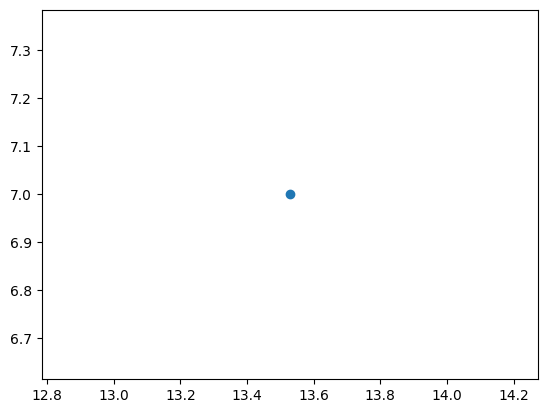

In [89]:
"""
Figura 2. Relació entre l’increment de cost entre l’escenari base i l’escenari de millora simulat (cost diferencial, en M€) 
i la reducció en el nombre d’incompliments. 
"""
x = []
y = []
for configuracio in configuracions:
    cost_diferencial = configuracio['Cost diferencial']
    n_incompliments = configuracio['Nombre incompliments'] 
    x.append(cost_diferencial / 1000000)
    y.append(incompliments_escenari_base - n_incompliments)
    
plt.scatter(x, y)
plt.show() 

In [90]:
pd.DataFrame({'Cost diferencial (M€)': x, 'Reducció nombre incompliments': y}) 

,Cost diferencial (M€),Reducció nombre incompliments
0,13.528496,7


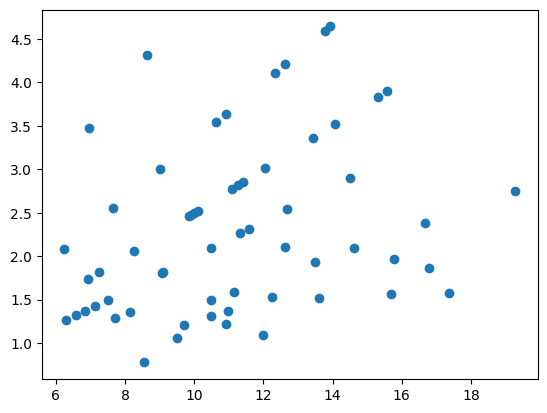

In [91]:
"""
Figura 3. Relació entre l’increment de cost entre l’escenari base i l’escenari de millora simulat (cost diferencial, en M€) 
i el quocient entre el cost diferencial i la reducció en el nombre d’incompliments. 
"""
x = []
y = []
for configuracio in configuracions:
    cost_diferencial = configuracio['Cost diferencial']
    n_incompliments = configuracio['Nombre incompliments']
    if n_incompliments < incompliments_escenari_base:
        x.append(cost_diferencial / 1000000)
        y.append((cost_diferencial / 1000000) / (incompliments_escenari_base - n_incompliments))
    
plt.scatter(x, y)
plt.show() 

In [92]:
pd.DataFrame({'Cost diferencial (M€)': x, 'Cost unitari reducció incompliments (M€)': y}) 

,Cost diferencial (M€),Cost unitari reducció incompliments (M€)
0,8.543056,0.776641
1,11.977083,1.088826
2,17.375624,1.579602
3,15.687071,1.568707
4,9.501988,1.055776
5,10.927457,1.214162
6,13.616619,1.512958
7,16.783128,1.864792
8,9.693413,1.211677
9,10.481518,1.310190


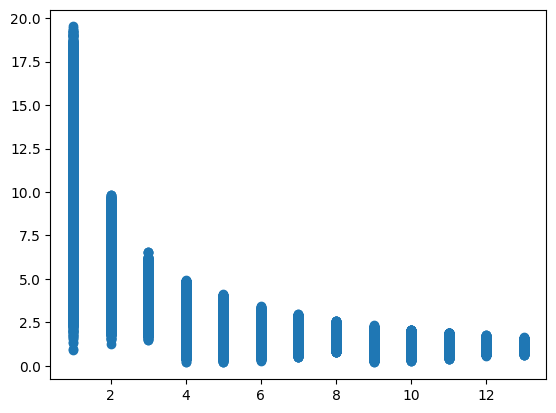

In [27]:
"""
Figura 4. Relació entre la reducció en el nombre d’incompliments i el quocient entre el cost diferencial 
i la reducció en el nombre d’incompliments (cost unitari reducció). 
"""
x = []
y = []
for configuracio in configuracions:
    cost_diferencial = configuracio['Cost diferencial']
    n_incompliments = configuracio['Nombre incompliments']
    
    if n_incompliments < incompliments_escenari_base:
        x.append(incompliments_escenari_base - n_incompliments)
        y.append((cost_diferencial / 1000000) / (incompliments_escenari_base - n_incompliments))
    
plt.scatter(x, y)
plt.show()

In [28]:
pd.DataFrame({"Reducció nombre d'incompliments": x, 'Cost unitari reducció incompliments (M€)': y}) 

,Reducció nombre d'incompliments,Cost unitari reducció incompliments (M€)
0,13,0.639773
1,13,0.643153
2,13,0.645190
3,13,0.648570
4,13,0.682904
...,...,...
1075229,1,19.229701
1075230,1,19.303251
1075231,1,19.318549
1075232,1,19.445432


In [73]:
import random

for i in range(20):
    print(10 + (20 - 10) * pow(random.random(), 0.5))

19.89994361579606
16.569635196828884
15.662158263606951
17.268638548325946
15.930932816704049
13.696800977689009
15.579754400524802
16.200086882608993
18.99684032428091
18.91131447461104
18.988766076235372
18.385736400223426
19.587787649994183
15.499248528815237
14.991545308862047
13.423032582431949
11.338351682983204
17.582332976726534
17.72153588862966
19.77480023711255
